# Logistic Regression

This section mentions how to train a model to classify handwritten digits. We will use the famous [MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28 x 28 pixels grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. The trained model is save to file after the training process.

Here are some sample images from the dataset:
![MNIST sample](images/mnist_samples.png)

<center>
    (image source: <a href="https://www.researchgate.net/publication/306056875_An_analysis_of_image_storage_systems_for_scalable_training_of_deep_neural_networks">researchgate.net</a>)
</center>

> We suppose that there'are linear lines separating digit groups.

The workflow is presented in the figure below.

![workflow](images/logistic_regression.svg)

## Import libraries

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 1. Prepare data

### 1.1 Convert train & test images to tensors

In [2]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

### 1.2 Split train images to train & validation sets

In [3]:
data_size = len(dataset)
train_size = round(data_size*0.8)
val_size = data_size - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

### 1.3 Define batch size & dataloaders

In [4]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

## 2. Create model

In [5]:
class MnistModel(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, out_classes)
    
    # hypothesis function, estimate label probabilities of an image
    def forward(self, X):
        X = X.reshape(-1, self.linear.in_features)
        Y_linear = self.linear(X)
        return Y_linear
    
    # predict label
    def predict(self, X):
        Y_linear = self(X)
        probs = F.softmax(Y_linear.detach(), dim=1)
        _, Y_hat = torch.max(probs, dim=1)
        return Y_hat
    
    # compute cost
    def cost_func(self, batch):
        images, labels = batch
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear, labels)
        return cost
    
    # evaluation
    def evaluate_batch(self, batch):
        images, labels = batch
        Y_hat = self.predict(images)
        acc = torch.sum(Y_hat == labels).item()/len(Y_hat)
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear.detach(), labels).item()
        log = {
            'cost': cost,
            'accuracy': acc
        }
        return log

In [6]:
in_features = 28*28  # flat an image to a vector
out_classes = 10  # there'are 10 classes of digits
model = MnistModel(in_features, out_classes)

## 3. Define optimizer

In [7]:
lr = 1e-3  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr)

## 4. Train model

In [8]:
def evaluate_epoch(batch_evals):
    batch_costs = [x['cost'] for x in batch_evals]
    batch_accs = [x['accuracy'] for x in batch_evals]    
    epoch_cost = sum(batch_costs)/len(batch_costs)
    epoch_acc = sum(batch_accs)/len(batch_accs)
    log = {
        'cost': epoch_cost,
        'accuracy': epoch_acc
    }
    return log

In [9]:
def fit(epochs, model, optimizer, train_loader, val_loader):
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost_func(batch)  # compute cost
            cost.backward()  # compute gradients
            optimizer.step()  # adjust parameters
            optimizer.zero_grad()  # reset gradients to zero
        
        # validation phase
        batch_evals = [model.evaluate_batch(batch) for batch in val_loader]
        epoch_eval = evaluate_epoch(batch_evals)
        logs.append(epoch_eval)
        print("epoch {}: validation cost = {}, validation accuracy = {}".format(
                i+1, round(epoch_eval['cost'],2), round(epoch_eval['accuracy'], 2))
             )
    return logs

In [10]:
epochs = 20
logs = fit(epochs, model, optimizer, train_loader, val_loader)

/home/tuanva/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch 1: validation cost = 1.96, validation accuracy = 0.63
epoch 2: validation cost = 1.7, validation accuracy = 0.71
epoch 3: validation cost = 1.5, validation accuracy = 0.75
epoch 4: validation cost = 1.35, validation accuracy = 0.77
epoch 5: validation cost = 1.24, validation accuracy = 0.79
epoch 6: validation cost = 1.14, validation accuracy = 0.8
epoch 7: validation cost = 1.07, validation accuracy = 0.81
epoch 8: validation cost = 1.01, validation accuracy = 0.81
epoch 9: validation cost = 0.96, validation accuracy = 0.82
epoch 10: validation cost = 0.91, validation accuracy = 0.83
epoch 11: validation cost = 0.88, validation accuracy = 0.83
epoch 12: validation cost = 0.84, validation accuracy = 0.83
epoch 13: validation cost = 0.82, validation accuracy = 0.84
epoch 14: validation cost = 0.79, validation accuracy = 0.84
epoch 15: validation cost = 0.77, validation accuracy = 0.84
epoch 16: validation cost = 0.75, validation accuracy = 0.84
epoch 17: validation cost = 0.73, va

### 4.1 Evaluations on validation set

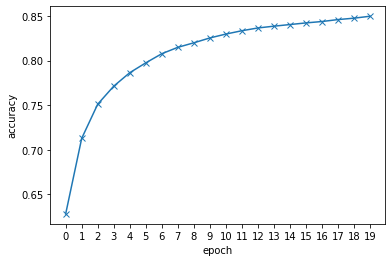

In [11]:
accuracies = [log['accuracy'] for log in logs]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(epochs))
plt.show();

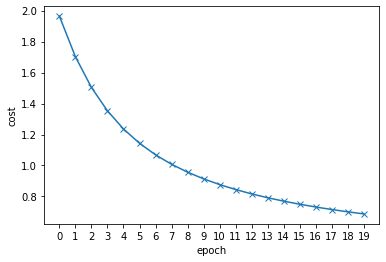

In [12]:
costs = [log['cost'] for log in logs]
plt.plot(costs, '-x')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.xticks(range(epochs))
plt.show();

### 4.2 Predict on test set

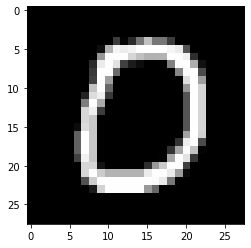

In [13]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray');

In [14]:
y_hat = model.predict(img)
print('Label: {}, Predicted: {}'.format(label, y_hat.item()))

Label: 0, Predicted: 0


### 4.3 Evaluation on test set

In [16]:
batch_evals = [model.evaluate_batch(batch) for batch in test_loader]
test_eval = evaluate_epoch(batch_evals)
print('test cost = {}, test accuracy = {}'.format(round(test_eval['cost'], 2), round(test_eval['accuracy'], 2)))

test cost = 0.65, test accuracy = 0.86


## 5. Save model

In [17]:
filename = 'mnist-logistic.pth'
torch.save(model.state_dict(), filename)

In [18]:
# initialize a new model
model2 = MnistModel(in_features, out_classes)
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0356,  0.0076, -0.0235,  ...,  0.0072, -0.0130, -0.0282],
                      [ 0.0167,  0.0208,  0.0107,  ...,  0.0055, -0.0215,  0.0074],
                      [-0.0023, -0.0166,  0.0099,  ...,  0.0168,  0.0062,  0.0312],
                      ...,
                      [ 0.0036,  0.0062, -0.0164,  ...,  0.0096, -0.0159, -0.0025],
                      [-0.0309,  0.0022,  0.0258,  ...,  0.0047, -0.0049,  0.0029],
                      [-0.0135, -0.0162, -0.0189,  ...,  0.0116,  0.0132,  0.0275]])),
             ('linear.bias',
              tensor([ 0.0317, -0.0097, -0.0266, -0.0296, -0.0095, -0.0272, -0.0004,  0.0048,
                       0.0022,  0.0084]))])

In [20]:
# load model from file
model2.load_state_dict(torch.load(filename))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0086, -0.0295,  0.0024,  ..., -0.0197, -0.0337,  0.0293],
                      [ 0.0309, -0.0322,  0.0288,  ...,  0.0090,  0.0194,  0.0114],
                      [-0.0257,  0.0327, -0.0148,  ..., -0.0102,  0.0200,  0.0042],
                      ...,
                      [ 0.0227, -0.0225, -0.0296,  ..., -0.0145,  0.0277,  0.0164],
                      [ 0.0054, -0.0311, -0.0038,  ..., -0.0273,  0.0130,  0.0025],
                      [-0.0125, -0.0234,  0.0332,  ..., -0.0282, -0.0158, -0.0023]])),
             ('linear.bias',
              tensor([-0.0438,  0.0726, -0.0057, -0.0212,  0.0006,  0.0546, -0.0323,  0.0541,
                      -0.0732, -0.0411]))])